In [1]:
!pip install ussa1976

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.2 MB/s eta 0:00:00


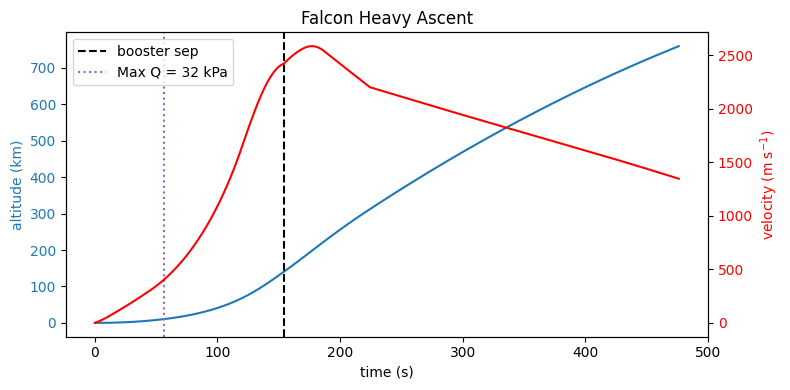

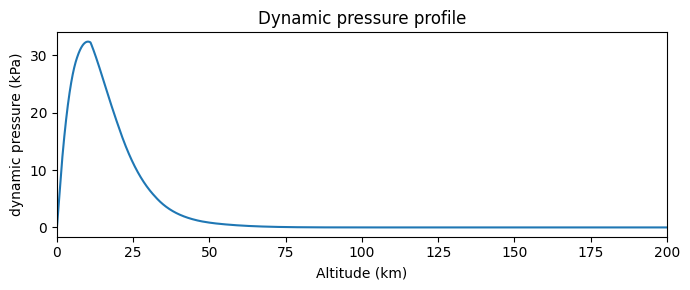

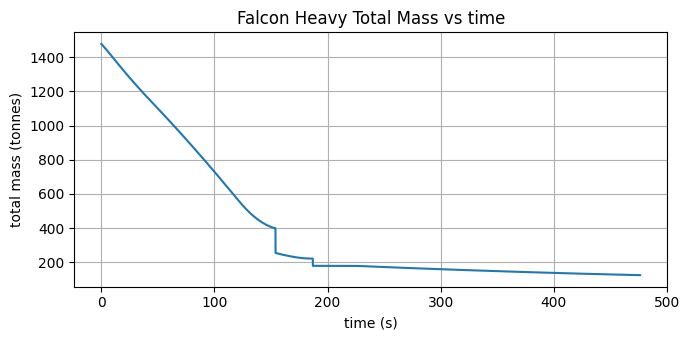

In [4]:
# 1D trajectory

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
import sympy as smp
import scipy.optimize as opt
import ussa1976 as usa
from dataclasses import dataclass
from functools import partial
from scipy.optimize import differential_evolution

#
# 1. Engine & Vehicle Data (boosters + core, sea-level thrust)
#
kN = 1_000
g0 = 9.81                                  # m s-2
P0 = 101325.0                               # Pa
R_E  = 6_371_000.0          # m, mean Earth radius
μ_E  = g0 * R_E**2

n_booster = 2 # Falcon heavy

n_engines_booster = 9
Thrust_booster_SL = 845 # sea level
Thrust_booster_Vac = 931

BOOSTER = dict(
    T_SL       = n_booster * n_engines_booster * Thrust_booster_SL * kN, # N   (18 SRMs @ 845 kN each)
    T_Vac       = n_booster * n_engines_booster * Thrust_booster_Vac * kN, # N   (18 SRMs @ 845 kN each)
    Isp_SL     = 282, # s
    Isp_Vac     = 311, # s
    burn    = 154, # s
    m_prop  = 410_900 * n_booster, # kg  (two boosters)
    m_dry   = 22_200 * n_booster # kg
)

n_engines_core = 9
Thrust_core_SL = 845 # sea level
Thrust_core_Vac = 981

CORE = dict(
    T_SL       = n_engines_core * Thrust_core_SL * kN, # N 9 Merlin engines
    T_Vac       = n_engines_core * Thrust_core_Vac * kN, # N 9 Merlin engines
    Isp_SL     = 283, # s
    Isp_Vac     = 311, # s Second stage engine has larger expansion ratio
    burn    = 187, # s
    m_prop  = 410_900, # kg
    m_dry   = 22_200 # kg
)

SECOND = dict(
    m_prop = 111_500,     # kg  (Merlin-Vac prop load; rough Falcon-9 upper)
    m_dry  =  4_000,      # kg  (dry hardware)
    T_vac  = 981 * kN,    # not used yet, but nice to store
    Isp_vac= 348,         #  –
    burn   = 397          #  –
)

second_knots   = np.array([0,   40, 330, SECOND['burn']])   # s since ignition
second_values  = np.array([1.0, 0.9, 0.4, 0.0])

throttle_knots  = np.array([0,  10,  45, 130, 170, CORE['burn']])   # s
throttle_values = np.array([0.7, 1.0, 0.7, 0.92, 0.40, 0.0]) # –

booster_knots  = np.array([0, 10, 45, 120, BOOSTER['burn']])   # s
booster_values = np.array([1.0,1.0,0.9, 1.0, 0.0]) # –


# Add its total mass to the payload the first stage is lifting

PAYLOAD = 63_800 # Heavy


Liftoff_mass = CORE['m_prop'] + CORE['m_dry'] + BOOSTER['m_prop'] + BOOSTER['m_dry'] + PAYLOAD

T_delay = 0.2 # 20% delay between stages
T_IGN = (1 + T_delay) * CORE['burn']

#
# 2. Helper Functions
#

Z     = np.arange(0.0, 1000_000.0, 100.0) # 0-1000 km, 100 m
atm   = usa.compute(z=Z, variables=["rho", "p"])  # get density & pressure

def pressure_ussa(h):
    return np.interp(h, atm.z.values, atm.p.values)   # Pa

def density_ussa(h):
    return np.interp(h, atm.z.values, atm.rho.values)

def surface_area(d, h):
    A_surf = np.pi * (d * h)
    return A_surf

def thrust_interp(stage, p):
    return stage['T_Vac'] - (stage['T_Vac'] - stage['T_SL']) * (p / P0)

def isp_interp(stage, p):
    return stage['Isp_Vac'] - (stage['Isp_Vac'] - stage['Isp_SL']) * (p / P0)

def throttle_core(t):
    return np.interp(t, throttle_knots, throttle_values)

def throttle_booster(t):
    return np.interp(t, booster_knots, booster_values)

def throttle_second(t):
    if t < T_IGN: # engine not lit yet
        return 0.0
    return np.interp(t - T_IGN, second_knots, second_values)

def gravity(h):
    return μ_E / (R_E + h)**2

d_core = 3.66
h_core = 70

d_booster = 3.66
h_booster = 41.2

h_core_2 = h_core - h_booster

# 3. ODE System Setup

S0 = [0.0, 0.0, BOOSTER['m_prop'], CORE['m_prop'], SECOND['m_prop']]

def derivatives(t, S):
    x, v, m_prop_b, m_prop_c, m_prop_s = S

    p_amb = pressure_ussa(x)
    rho   = density_ussa(x)
    g = gravity(x)

    #booster_attach = m_prop_b > 0.05 * BOOSTER['m_prop']
    booster_attach = t <= BOOSTER['burn']
    #stage_one_attach = m_prop_c > 0.05 * CORE['m_prop']
    stage_one_attach = t <= CORE['burn']

    if booster_attach and m_prop_b > 0:
        throttle_b = throttle_booster(t)
        T_b   = throttle_b * thrust_interp(BOOSTER, p_amb)
        Isp_b = isp_interp(BOOSTER, p_amb)
        mdot_b = T_b / (Isp_b * g0)
        dmp_b_dt = -mdot_b

    else:                               # detached -> no thrust, no mass flow
        T_b, dmp_b_dt = 0.0, 0.0            # ignore whatever is left

    # core
#    if m_prop_c > 0 and t <= CORE['burn']:
    if stage_one_attach and m_prop_c > 0:
        throttle = throttle_core(t)                      # NEW
        T_c = throttle * thrust_interp(CORE, p_amb)      # UPDATED
        Isp_c = isp_interp(CORE, p_amb)
        mdot_c = T_c / (Isp_c * g0)
        #mdot_c   = CORE['m_prop'] / CORE['burn']    # <- constant mdot
        dmp_c_dt = -mdot_c
    else:
        T_c, dmp_c_dt = 0.0, 0.0


    if (t >= T_IGN) and (m_prop_s > 0):
      throttle_s  = throttle_second(t)
      T_s         = throttle_s * SECOND['T_vac']
      mdot_s      = T_s / (SECOND['Isp_vac'] * g0)      # use g, not local g
      dmp_s_dt    = -mdot_s
    else:
      T_s, dmp_s_dt = 0.0, 0.0

    if m_prop_b <= 0: m_prop_b, dmp_b_dt = 0.0, 0.0
    if m_prop_c <= 0: m_prop_c, dmp_c_dt = 0.0, 0.0
    if m_prop_s <= 0: m_prop_s, dmp_s_dt = 0.0, 0.0

    # totals
    thrust = T_b + T_c + T_s

    if booster_attach:
        booster_mass = BOOSTER['m_dry'] + m_prop_b   # still bolted on
    else:
        booster_mass = 0.0                           # already dropped

    if stage_one_attach:
        first_stage_mass = CORE['m_dry'] + m_prop_c   # still bolted on
    else:
        first_stage_mass = 0.0                           # already dropped

    second_stage_mass = SECOND['m_dry'] + m_prop_s

    mass = booster_mass + first_stage_mass + second_stage_mass + PAYLOAD

    A_eff  = (np.pi*d_core**2/4) + (2*np.pi*d_booster**2/4 if booster_attach else 0.0)  # ref areas
    Cd     = 0.3
    drag   = 0.5*rho*Cd*A_eff*v*abs(v)

    dv_dt, dx_dt = (thrust-drag)/mass - g, v
    return [dx_dt, dv_dt, dmp_b_dt, dmp_c_dt, dmp_s_dt]


#
# 4. Integrate the ODE System
#

t_end = SECOND['burn'] * 1.2 # end of first stage

sol   = solve_ivp(derivatives, [0, t_end], S0,
                  max_step=0.1, dense_output=True)

t   = sol.t
alt = sol.y[0] # metres
vel = sol.y[1] # m s-1



rho = density_ussa(alt) # vectorised lookup
q    = 0.5 * rho * vel**2 # Pa  (N m-2)

imax = np.argmax(q) # index of dynamic pressure (Q)
t_maxq = t[imax];  q_max = q[imax]

m_prop_b  = sol.y[2]
m_prop_c  = sol.y[3]
m_prop_s = sol.y[4]

booster_dry = BOOSTER['m_dry']         # (both side boosters together)
core_dry    = CORE['m_dry']
second_dry    = SECOND['m_dry']

booster_present = (t < BOOSTER['burn']).astype(float)
#core_present = (m_prop_c > 0.05 * CORE['m_prop']).astype(float)
core_present    = (t < CORE['burn']).astype(float)
second_present = (t < T_IGN + SECOND['burn']).astype(float)

total_mass = (
      booster_present * booster_dry     # add dry boosters only when present
    + core_dry * core_present
    + second_dry * second_present
    + m_prop_b * booster_present
    + m_prop_c * core_present
    + m_prop_s * second_present
    + PAYLOAD
)

#
# 5. Plot altitude & velocity
#

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(t, alt/1e3)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('altitude (km)', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_title('Falcon Heavy Ascent')

ax2 = ax1.twinx()
ax2.plot(t, vel, 'r')
ax2.set_ylabel('velocity (m s$^{-1}$)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# event markers
ax1.axvline(BOOSTER['burn'], ls='--', color='k', label='booster sep')
ax1.axvline(t_maxq, ls=':', color='tab:purple', label=f'Max Q = {q_max/1e3:.0f} kPa')

ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
plt.plot(alt/1e3, q/1e3)
plt.xlim(0, 200)
#plt.axvline(t_maxq, ls=':', color='k')
#plt.text(t_maxq, q_max/1e3, f'  Max Q {q_max/1e3:.1f} kPa', va='bottom')
plt.xlabel('Altitude (km)'); plt.ylabel('dynamic pressure (kPa)')
plt.title('Dynamic pressure profile')
plt.tight_layout()
plt.show()

# Plot mass
plt.figure(figsize=(7,3.5))
plt.plot(sol.t, total_mass/1e3)
plt.xlabel('time (s)')
plt.ylabel('total mass (tonnes)')
plt.title('Falcon Heavy Total Mass vs time')
plt.grid(True)
plt.tight_layout()
plt.show()